In [57]:
import pandas as pd
import numpy as np
import pickle 
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from scipy import stats
% matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [58]:
#data cleaning and formatting
def DataFormat (file_name):
    movie_raw = pd.read_csv(file_name, encoding = "ISO-8859-1")
    movie_1 = movie_raw.dropna(how = 'any') #clean up rows with incomplete information
    movie_2 = movie_1.copy()
    movie_2['Budget'] = pd.to_numeric(movie_1['Budget'], errors='coerce') #transform strings to number
    movie_2['Gross worldwide'] = pd.to_numeric(movie_2['Gross worldwide'], errors='coerce')
    movie_2.rename(columns={'Gross worldwide': 'Gross_worldwide', 'Gross USA': 'Gross_USA', 
                      'Opening Weekend USA' : 'Opening_Weekend_USA', 'Rating Number': 'Rating_Number'}, inplace=True)
    movie_3 = movie_2.copy()
    movie_3['Runtime'] = (movie_2['Runtime'].str.split(' ', expand = False)) #extract number from runtime
    movie_3['Runtime_1'] = movie_3['Runtime'].apply(lambda x: x[0])
    movie_4 = movie_3.drop(columns=['Runtime']).copy()
    movie_4.rename(columns={'Runtime_1': 'Runtime'}, inplace=True)
    movie_4['Runtime'] = pd.to_numeric(movie_4['Runtime'],errors='coerce')
    movie_4['Rating'] = pd.to_numeric(movie_4['Rating'],errors='coerce')
    movie_5 = movie_4.dropna(how = 'any')
    movie_5.drop_duplicates(subset='Title', inplace=True) #clean up duplicate rows
    
    movie_6 = movie_5.copy()
    #create cloumns based on genres 
    movie_6['Comedy'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Comedy' else 0)
    movie_6['Drama'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Drama' else 0)
    movie_6['Action'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Action' else 0)
    movie_6['Biography'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Biography' else 0)
    movie_6['Horror'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Horror' else 0)
    movie_6['Adventure'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Adventure' else 0)
    movie_6['Animation'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Animation' else 0)
    movie_6['Crime'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Crime' else 0)
    movie_6['Documentary'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Documentary' else 0)
    movie_6['Mystery'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Mystery' else 0)
    movie_6['Fantasy'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Fantasy' else 0)
    movie_6['Sci-Fi'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Sci-Fi' else 0)
    movie_6['Family'] = movie_6['Genres'].apply(lambda x: 1 if x == 'Family' else 0)
    
    movie_7 = movie_6[['Gross_worldwide','Budget','Opening_Weekend_USA','Rating','Runtime',
                       'Comedy', 'Drama', 'Action', 'Biography', 'Horror', 'Adventure','Animation', 
                       'Crime', 'Documentary','Mystery', 'Fantasy','Sci-Fi','Family']]
    
    
    return movie_7

In [59]:
# #Transformation of some of the numeric data to normal distribution
# def DataTransformation(Dataframe):
#     Temp_transform = Dataframe.copy()
#     Temp_transform = Temp_transform.reset_index(drop=True)
#     gross_world_wide_transform = stats.boxcox(Dataframe['Gross_worldwide'])
#     #Budget_transform = stats.boxcox(Dataframe['Budget'])
#     Openning_weekend_transform = stats.boxcox(Dataframe['Opening_Weekend_USA'])
#     #rating_transform = stats.boxcox(Dataframe['Rating'])
#     #runtime_transform = stats.boxcox(Dataframe['Runtime'])
#     Temp_transform['gross_world_wide_transform'] = pd.Series(gross_world_wide_transform[0])
#     #Temp_transform['Budget_transform'] = pd.Series(Budget_transform[0])
#     Temp_transform['Openning_weekend_transform'] = pd.Series(Openning_weekend_transform[0])
#     #Temp_transform['rating_transform'] = pd.Series(rating_transform[0])
#     #Temp_transform['runtime_transform'] = pd.Series(runtime_transform[0])
#     Temp_transform_cleanup = Temp_transform[['gross_world_wide_transform', 'Budget',
#                                          'Openning_weekend_transform', 'Rating', 
#                                          'Runtime', 'Comedy','Drama', 'Action', 
#                                          'Biography', 'Horror', 'Adventure', 'Animation',
#                                          'Crime', 'Documentary', 'Mystery', 'Fantasy', 'Sci-Fi', 'Family']]
#     return Temp_transform_cleanup

# Was trying some transformation to get residual distribution more normal, however, it didn't help too much and the 
#performance was worse, so did not use the transformation

In [60]:
movie_info = DataFormat('181011_movie_file_training.csv')

In [61]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1835 entries, 0 to 127680
Data columns (total 18 columns):
Gross_worldwide        1835 non-null float64
Budget                 1835 non-null float64
Opening_Weekend_USA    1835 non-null float64
Rating                 1835 non-null float64
Runtime                1835 non-null int64
Comedy                 1835 non-null int64
Drama                  1835 non-null int64
Action                 1835 non-null int64
Biography              1835 non-null int64
Horror                 1835 non-null int64
Adventure              1835 non-null int64
Animation              1835 non-null int64
Crime                  1835 non-null int64
Documentary            1835 non-null int64
Mystery                1835 non-null int64
Fantasy                1835 non-null int64
Sci-Fi                 1835 non-null int64
Family                 1835 non-null int64
dtypes: float64(4), int64(14)
memory usage: 272.4 KB


In [62]:
#split training and test set
x_movie = movie_info.drop(['Gross_worldwide'],axis =1 )
y_movie = movie_info['Gross_worldwide']
xtrain, xtest, ytrain, ytest = train_test_split(x_movie, y_movie, test_size=0.3)

In [63]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1284 entries, 45463 to 32290
Data columns (total 17 columns):
Budget                 1284 non-null float64
Opening_Weekend_USA    1284 non-null float64
Rating                 1284 non-null float64
Runtime                1284 non-null int64
Comedy                 1284 non-null int64
Drama                  1284 non-null int64
Action                 1284 non-null int64
Biography              1284 non-null int64
Horror                 1284 non-null int64
Adventure              1284 non-null int64
Animation              1284 non-null int64
Crime                  1284 non-null int64
Documentary            1284 non-null int64
Mystery                1284 non-null int64
Fantasy                1284 non-null int64
Sci-Fi                 1284 non-null int64
Family                 1284 non-null int64
dtypes: float64(3), int64(14)
memory usage: 180.6 KB


In [64]:
#Combine the x and y in training set into one dataset for removing outliers and scale
Train_data_set = xtrain.copy()
Train_data_set['Gross_worldwide'] = ytrain 

In [65]:
#Combine the x and y in test set into one dataset for later scale

Test_data_set = xtest.copy()
Test_data_set['Gross_worldwide'] = ytest

In [66]:
#removing really extreme outliers in training set

def RemoveOutliers(Dataframe):
    
    q25, q50, q75 = np.percentile(Dataframe['Gross_worldwide'], [25,50,75])
    iqr = q75 - q25
    Min = q25 - 5*(iqr)
    Max= q75 + 5*(iqr)
    movie_info_filtered = Dataframe[(Dataframe['Gross_worldwide'] < Max)&(Dataframe['Gross_worldwide'] > Min)]
    return movie_info_filtered


In [67]:
Train_data_set_remove_outlier = RemoveOutliers(Train_data_set)

In [68]:
Train_data_set_remove_outlier['Gross_worldwide'].describe()

count    1.267000e+03
mean     1.626612e+08
std      1.933670e+08
min      6.503000e+03
25%      3.904255e+07
50%      9.759414e+07
75%      1.999206e+08
max      1.025467e+09
Name: Gross_worldwide, dtype: float64

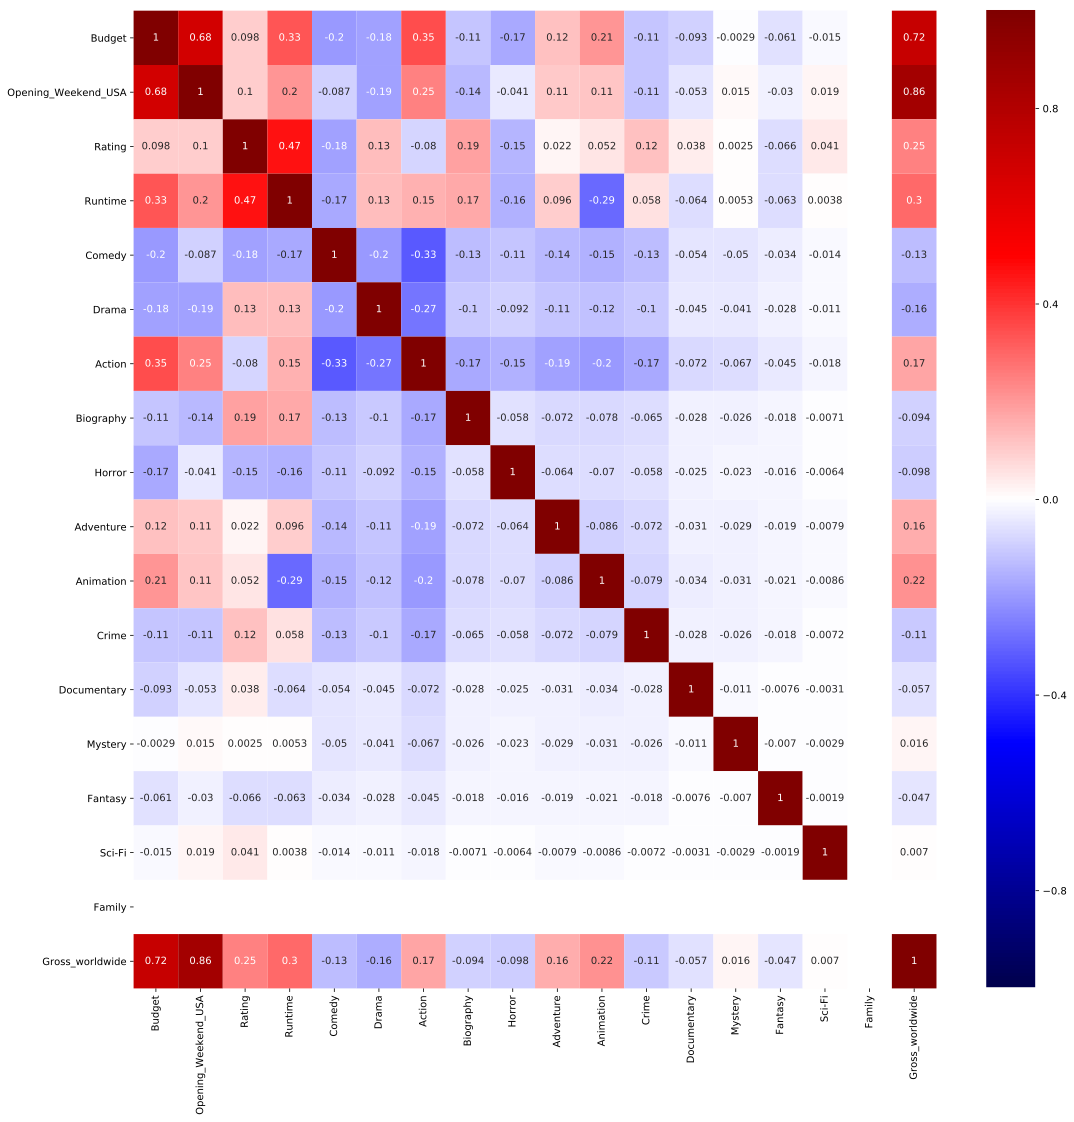

In [69]:
#explore correlation between response varible and features, also examing co-linearity

corr_1 = Train_data_set_remove_outlier.corr()
fig, ax = plt.subplots(figsize=(18,18))   
corr_heatmap = sns.heatmap(corr_1, cmap="seismic", annot=True, vmin=-1, vmax=1)

#might remove some catergorical variables since they have low correlations, but will first try some model fitting

In [70]:
#try fit the model and select features
#select all the features
y, X = patsy.dmatrices('Gross_worldwide ~ Budget  + Opening_Weekend_USA + Rating + Runtime + Adventure + Animation + Action + Comedy + Drama + Biography + Horror + Crime + Documentary + Mystery + Fantasy + Family' , data=Train_data_set_remove_outlier, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit_filter = model.fit()

# Print summary statistics of the model's performance
fit_filter.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Gross_worldwide   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     359.0
Date:                Sat, 13 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:13:04   Log-Likelihood:                -24915.
No. Observations:                1267   AIC:                         4.986e+04
Df Residuals:                    1251   BIC:                         4.994e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2.844e+08   6.34e+07     -4.487      0.000   -4.09e+08    -1.6e+08
Budget                  0.8681      0.078     11.194      0.000       0.716       1.020
Opening_Weekend_USA     5.4569      0.139     39.371      0.000       5.185       5.729
Rating               2.528e+07   2.91e+06      8.684      0.000    1.96e+07     3.1e+07
Runtime              6.389e+05   1.85e+05      3.460      0.001    2.77e+05       1e+06
Adventure            8.778e+07   6.05e+07      1.451      0.147   -3.09e+07    2.06e+08
Animation            1.187e+08   6.05e+07      1.963      0.050    5.69e+04    2.37e+08
Action               3.205e+07      6e+07      0.534      0.594   -8.57e+07     1.5e+08
Comedy               5.554e+07   6.01e+07      0.924      0.356   -6.23e+07    1.73e+08
Drama                4.397e+07   6.02e+07      0.731      0.465   -7.41e+07    1.62e+08
Biography            4.443e+07   6.06e+07      0.733      0.464   -7.45e+07    1.63e+08
Horror               4.825e+07   6.08e+07      0.793      0.428   -7.11e+07    1.68e+08
Crime                3.359e+07   6.06e+07      0.555      0.579   -8.52e+07    1.52e+08
Documentary          4.797e+07   6.36e+07      0.754      0.451   -7.69e+07    1.73e+08
Mystery              6.399e+07   6.42e+07      0.996      0.319    -6.2e+07     1.9e+08
Fantasy              4.849e+07   6.92e+07      0.701      0.483   -8.72e+07    1.84e+08
Family                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                      421.112   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2918.131
Skew:                           1.359   Prob(JB):                         0.00
Kurtosis:                       9.920   Cond. No.                          inf
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [71]:
#try fit the model and select features
#try remove all the categorical variables
y, X = patsy.dmatrices('Gross_worldwide ~ Budget  + Opening_Weekend_USA + Rating + Runtime' , data=Train_data_set_remove_outlier, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit_filter = model.fit()

# Print summary statistics of the model's performance
fit_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Gross_worldwide   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1239.
Date:                Sat, 13 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:13:04   Log-Likelihood:                -24961.
No. Observations:                1267   AIC:                         4.993e+04
Df Residuals:                    1262   BIC:                         4.996e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -2.026e+08   1.83e+07    -11.054      0.000   -2.39e+08   -1.67e+08
Budget                  1.0089      0.071     14.230      0.000       0.870       1.148
Opening_Weekend_USA     5.4234      0.140     38.683      0.000       5.148       5.698
Rating               3.057e+07    2.8e+06     10.901      0.000    2.51e+07    3.61e+07
Runtime             -6996.4031   1.65e+05     -0.042      0.966   -3.31e+05    3.17e+05
==============================================================================
Omnibus:                      486.871   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3795.879
Skew:                           1.574   Prob(JB):                         0.00
Kurtosis:                      10.874   Cond. No.                     5.91e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
#try fit the model and select features
#try remove all the categorical variables
#further remove runtime
y, X = patsy.dmatrices('Gross_worldwide ~ Budget  + Opening_Weekend_USA + Rating' , data=Train_data_set_remove_outlier, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit_filter = model.fit()

# Print summary statistics of the model's performance
fit_filter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Gross_worldwide   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1654.
Date:                Sat, 13 Oct 2018   Prob (F-statistic):               0.00
Time:                        15:13:04   Log-Likelihood:                -24961.
No. Observations:                1267   AIC:                         4.993e+04
Df Residuals:                    1263   BIC:                         4.995e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -2.03e+08   1.61e+07    -12.589      0.000   -2.35e+08   -1.71e+08
Budget                  1.0080      0.068     14.840      0.000       0.875       1.141
Opening_Weekend_USA     5.4237      0.140     38.770      0.000       5.149       5.698
Rating               3.051e+07   2.48e+06     12.304      0.000    2.56e+07    3.54e+07
==============================================================================
Omnibus:                      486.743   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3794.300
Skew:                           1.573   Prob(JB):                         0.00
Kurtosis:                      10.872   Cond. No.                     5.24e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.24e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

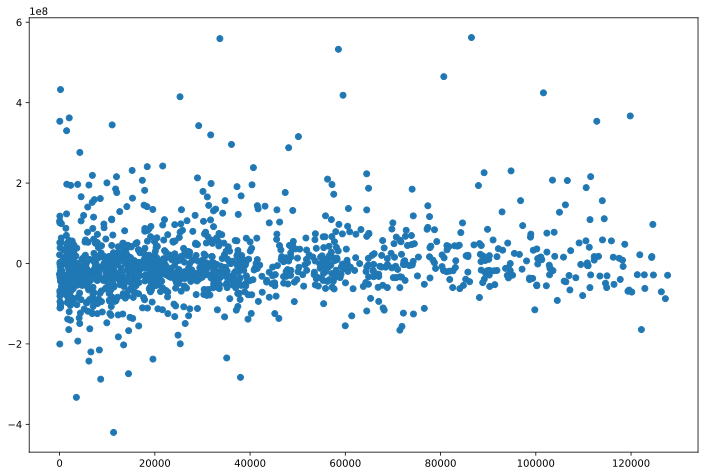

In [73]:
#examing the residual, lookes balance along x axis
fit_filter.resid.plot(style='o', figsize=(12,8))

In [74]:
#scale the training data
def DataScale(Train_Dataframe, Test_Dataframe):  
    scaler = StandardScaler()
    scaler.fit(Train_Dataframe)
    train_data_scale = scaler.transform(Train_Dataframe)
    train_data_scale_df = pd.DataFrame(train_data_scale, columns = Train_Dataframe.columns )
    test_data_scale = scaler.transform(Test_Dataframe)
    test_data_scale_df = pd.DataFrame(test_data_scale, columns = Test_Dataframe.columns )
    
    
    return train_data_scale_df, test_data_scale_df


In [75]:
Train_data_set_remove_outlier_scale, Test_data_scale  = DataScale(Train_data_set_remove_outlier,Test_data_set)

In [76]:
Test_data_scale.head()

,Budget,Opening_Weekend_USA,Rating,Runtime,Comedy,Drama,Action,Biography,Horror,Adventure,Animation,Crime,Documentary,Mystery,Fantasy,Sci-Fi,Family,Gross_worldwide
0,-0.375175,-0.574600,-1.956764,-1.604457,-0.494568,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,3.259425,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.506483
1,2.235036,1.484047,1.363350,-0.426970,-0.494568,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,3.259425,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,2.561771
2,-0.966550,-0.870471,0.960912,-0.314829,2.021968,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.513198
3,0.093847,-0.159425,0.256646,0.189809,-0.494568,-0.406932,1.519241,-0.254374,-0.226831,-0.281454,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.297274
4,-0.212037,0.091046,-0.246402,-0.875537,-0.494568,-0.406932,1.519241,-0.254374,-0.226831,-0.281454,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.436999


In [77]:
Train_data_set_remove_outlier_scale.head()

,Budget,Opening_Weekend_USA,Rating,Runtime,Comedy,Drama,Action,Biography,Horror,Adventure,Animation,Crime,Documentary,Mystery,Fantasy,Sci-Fi,Family,Gross_worldwide
0,-0.191644,-0.002124,1.665179,2.432641,-0.494568,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,-0.306803,3.904304,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.209708
1,-0.701451,-0.421573,0.457865,0.414092,-0.494568,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,-0.306803,3.904304,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.557369
2,0.705616,-0.271491,-0.648840,-0.202687,-0.494568,-0.406932,-0.658223,-0.254374,-0.226831,3.552978,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,0.192400
3,-0.660666,-0.522372,-0.648840,-0.931607,-0.494568,-0.406932,1.519241,-0.254374,-0.226831,-0.281454,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.668882
4,-0.793216,-0.657937,-0.145792,-0.090545,2.021968,-0.406932,-0.658223,-0.254374,-0.226831,-0.281454,-0.306803,-0.256128,-0.109457,-0.101818,-0.068979,-0.028105,0.0,-0.771073


In [78]:
#Use cross validation to determine alphas and degree

def CrossValidation(degree,X_train_all,y_train_all):
    
    kf = KFold(n=len(X_train_all), n_folds=5, shuffle=True)
    alphas=np.linspace(1e-5,1,1000)
    #alphas = [0]
    mse_for_alpha=[]
    r2_for_alpha=[]
    adj_r2_for_alpha=[]
    for a in alphas:
        mse_score=[]
        r2_score=[]
        adj_r2_score=[]
        est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=a))
        for train, test in kf:
            #print (train,test)
            x_train=X_train_all.iloc[train]
            y_train=y_train_all.iloc[train]
            x_test=X_train_all.iloc[test]
            y_test=y_train_all.iloc[test]
            #print (type(y_test), type(x_test))
            model = est.fit(x_train,y_train)
            #print (type(model))
            #print (len(model.named_steps.polynomialfeatures.powers_),
                   #model.named_steps.polynomialfeatures.powers_,
                   #model.named_steps.elasticnet.sparse_coef_, model.named_steps.elasticnet.intercept_)
            #print ('est', est)
            mse=np.mean((y_test-model.predict(x_test))**2)
            r2 = model.score(x_test,y_test)
            mse_score.append(mse)
            r2_score.append(r2)
            coefs = model.named_steps.elasticnet.coef_
            #print(coefs)
            coefs_sig = coefs[coefs > 1e-5]
            feature_num = len(coefs_sig)
            adj_r2 = r2 - (1-r2)*feature_num/(len(x_test)-feature_num-1)
            adj_r2_score.append(adj_r2)
        mse_for_alpha.append(np.mean(mse_score))
        r2_for_alpha.append(np.mean(r2_score))
        adj_r2_for_alpha.append(np.mean(adj_r2_score))
        
    plt.scatter(x=alphas, y= mse_for_alpha, label = 'mse')
    
    #plt.scatter(x=alphas, y= r2_for_alpha)
    plt.scatter(x=alphas, y= adj_r2_for_alpha, label = 'ajusted_R2')
   
    
    mse_alpha_pair = zip(mse_for_alpha, alphas)
    mse_alpha_pair_sorted = sorted(mse_alpha_pair)
    
    
    r2_alpha_pair = zip(r2_for_alpha, alphas)
    r2_alpha_pair_sorted = sorted(r2_alpha_pair, reverse  = True)
    
    adj_r2_alpha_pair = zip(adj_r2_for_alpha, alphas)
    adj_r2_alpha_pair_sorted = sorted(adj_r2_alpha_pair, reverse  = True)
    #print (adj_r2_alpha_pair_sorted)
    
    return mse_alpha_pair_sorted[0], r2_alpha_pair_sorted[0], adj_r2_alpha_pair_sorted[0]

%config InlineBackend.figure_format = 'svg'

In [79]:
train_data = Train_data_set_remove_outlier_scale[['Budget', 'Opening_Weekend_USA', 'Rating']]
y_train = Train_data_set_remove_outlier_scale['Gross_worldwide']


((0.20412422605934935, 0.0030129729729729735), (0.7968519552731069, 0.0030129729729729735), (0.7944089667312662, 0.0030129729729729735))


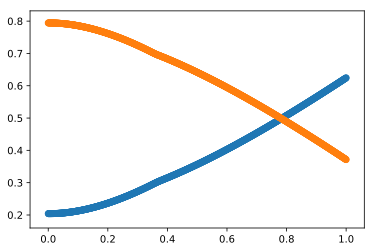

In [80]:
#compare performance at different polynomial degrees
#degree 1
print (CrossValidation(1,train_data,y_train))


((0.19314764589181407, 1e-05), (0.8055964022463963, 0.01802783783783784), (0.8001918545629941, 0.017026846846846848))


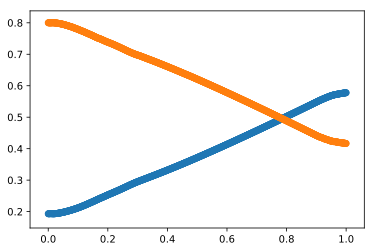

In [81]:
#compare performance at different polynomial degrees
#degree 2
print (CrossValidation(2,train_data,y_train))

((0.18275654126569038, 0.0060159459459459465), (0.8151656187747859, 0.0060159459459459465), (0.8056584773982143, 0.014023873873873875))


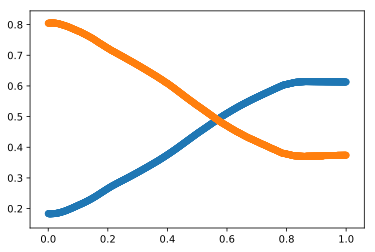

In [82]:
#compare performance at different polynomial degrees
#degree 3
print (CrossValidation(3,train_data,y_train))

((0.1889403529062456, 0.015024864864864866), (0.8101815858770985, 0.015024864864864866), (0.796340878354999, 0.017026846846846848))


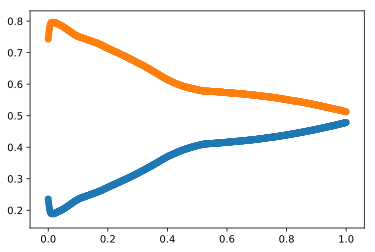

In [83]:
#compare performance at different polynomial degrees
#degree 4
print (CrossValidation(4,train_data,y_train))

In [84]:
#based on the performance at different degree, the best is degree 3 with lamda = 0.006

In [85]:
#seperate the test_set after scaling
x_test_scale = Test_data_scale[['Budget', 'Opening_Weekend_USA', 'Rating']]
y_test_scale = Test_data_scale['Gross_worldwide']


r2_score 0.7173784130491467 mse 0.32625968005093703


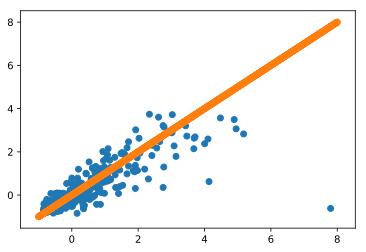

<Figure size 1440x1440 with 0 Axes>

In [94]:
#fit the model with test set and see how it performs

est = make_pipeline(PolynomialFeatures(3), ElasticNet(alpha= 0.006))
model = est.fit(train_data,y_train)
y_predic_test = model.predict(x_test_scale)
res = y_test_scale - y_predic_test

r2_score = model.score(x_test_scale,y_test_scale)
# coefs = model.named_steps.elasticnet.coef_
#  coefs_sig = coefs[coefs > 1e-5]
# feature_num = len(coefs_sig)
#adj_r2 = r2_score - (1-r2_score)*feature_num/(len(x_test_scale)-feature_num-1)
mse = np.mean((y_test_scale - model.predict(x_test_scale))**2)

plt.scatter(x= y_test_scale, y= y_predic_test)

y_figure = np.linspace(-1,8,1000)
x_figure = np.linspace(-1,8,1000)


plt.scatter(x= x_figure , y= y_figure)
plt.figure(figsize=(20, 20))
print ('r2_score', r2_score, 'mse', mse)

In [93]:
#trasform the MSE back to number 
gross_world_wide_std = np.std(ytrain)
MSE_test = gross_world_wide_std*mse
root_mean_square_error = MSE_test**0.5
root_mean_square_error,MSE_test

(8866.033703523492, 78606553.63201447)

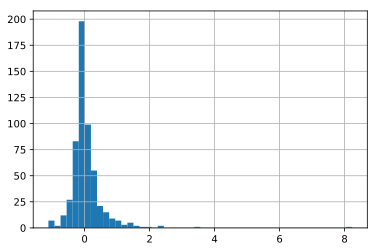

In [88]:
#examine the residual
res.hist(bins = 50)

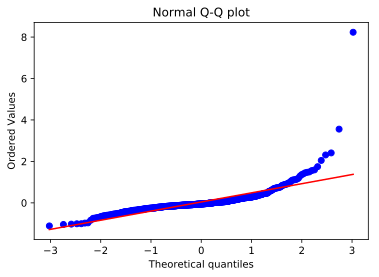

In [89]:
#look at whether the residual is normally distributed
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [90]:
#Overall, the model performs quite well with the test set, with R2 at 0.72 and MSE at 0.36 std 
#But noted that the model performs better with low budget small movies, but rather poorly with high budget movies
#Might need to think about other model to handel high budget movies

#The residual does not follow normal distribution. Tried transform the variable but did not help. 
